# Supp Fig3 Malignant activity in Skin vs Blood


In [1]:
library(magrittr)
library(tidyverse)
library(patchwork)

library(SingleCellExperiment)
library(scran)

library(multisce)
library(scutility)

library(pheatmap)

── Attaching packages ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.5.0 
✔ readr   2.1.2      ✔ forcats 0.5.2 
── Conflicts ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::extract()   masks magrittr::extract()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::lag()       masks stats::lag()
✖ purrr::set_names() masks magrittr::set_names()
Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘matrixStats’


The following object is masked from ‘package:dplyr’:

    count



Attaching package: ‘MatrixGenerics’


The following objec

In [2]:
# Set default ggplot2 theme
theme_set(theme_bw(base_size=12) + theme(panel.grid=element_blank(), 
                             panel.border=element_blank(), 
                             axis.title=element_blank(), 
                             #axis.text=element_blank(), 
                             axis.line = element_line(arrow=arrow(length=unit(2, "mm"))),
                             strip.text = element_text(size=12),
                             strip.background=element_blank()))

### Load samples from Herrera et al. 2021

This study included scTCR+CITE-seq from matched skin and blood of six Sézary Syndrome patients (GSE171811).

These samples were reanalyzed and preprocessed similar to the SS17 sample included in the study.

In [3]:
donors <- c("SS1", "SS2", "SS3", "SS4", "SS5", "SS6") %>% paste0("Herrera_", .) %>% setNames(.,.)

sce_list <- donors %>% map(~ multisce_load(path=here::here("data","multisce", .x), main_prefix="RNA", altexp_include=c("TF", "ADT"), reduceddim_include="umap"))

Loading RNA from /home/tbb/git/CTCL_SE_drug_resistance/data/multisce/Herrera_SS1/sce/RNA.rds

Loading coldata from /home/tbb/git/CTCL_SE_drug_resistance/data/multisce/Herrera_SS1/coldata.rds

Loading TF from /home/tbb/git/CTCL_SE_drug_resistance/data/multisce/Herrera_SS1/sce/TF.rds

Loading ADT from /home/tbb/git/CTCL_SE_drug_resistance/data/multisce/Herrera_SS1/sce/ADT.rds

Loading umap from /home/tbb/git/CTCL_SE_drug_resistance/data/multisce/Herrera_SS1/reducedDim/umap.rds

Loading RNA from /home/tbb/git/CTCL_SE_drug_resistance/data/multisce/Herrera_SS2/sce/RNA.rds

Loading coldata from /home/tbb/git/CTCL_SE_drug_resistance/data/multisce/Herrera_SS2/coldata.rds

Loading TF from /home/tbb/git/CTCL_SE_drug_resistance/data/multisce/Herrera_SS2/sce/TF.rds

Loading ADT from /home/tbb/git/CTCL_SE_drug_resistance/data/multisce/Herrera_SS2/sce/ADT.rds

Loading umap from /home/tbb/git/CTCL_SE_drug_resistance/data/multisce/Herrera_SS2/reducedDim/umap.rds

Loading RNA from /home/tbb/git/CTCL_SE

Filter to only include samples with sufficient malignant T cells in both blood and skin for robust comparisons.

In [4]:
# determine which samples contain sufficient viable and high quality malignant T cells in matched blood and skin

malignant_count_skin <- imap(sce_list, ~ {
    subset <- which(.x$cell_type == "Malignant")
    
    malignant_count <- table(.x$Tissue[subset], .x$TRB_top5[subset])[,1]
    return(malignant_count)
})

malignant_count_skin %<>% bind_rows(.id="sample")
print(malignant_count_skin)

# filter to only include samples with at least 20 viable malignant T cells from skin compartment
sce_list %<>% .[names(.) %in% malignant_count_skin$sample[malignant_count_skin$Skin >= 20]]
sce_list %>% names

# A tibble: 6 × 3
  sample      Blood  Skin
  <chr>       <int> <int>
1 Herrera_SS1  1535    63
2 Herrera_SS2   384     3
3 Herrera_SS3  1097    22
4 Herrera_SS4   234   142
5 Herrera_SS5   726     0
6 Herrera_SS6  1104     0


[1] "Herrera_SS1" "Herrera_SS3" "Herrera_SS4"

### Load scTCR+CITE-seq data generated in this study

This object includes the matched skin biopsy from the patient

In [5]:
sce <- multisce_load(path=here::here("data", "multisce", "SS17_skin"), main_name="RNA", reduceddim_include="umap", altexp_include=c("ADT", "TF"), metadata_include="colors")

Loading RNA from /home/tbb/git/CTCL_SE_drug_resistance/data/multisce/SS17_skin/sce/RNA.rds

Loading coldata from /home/tbb/git/CTCL_SE_drug_resistance/data/multisce/SS17_skin/coldata.rds

Loading colors from /home/tbb/git/CTCL_SE_drug_resistance/data/multisce/SS17_skin/metadata/colors.rds

Loading ADT from /home/tbb/git/CTCL_SE_drug_resistance/data/multisce/SS17_skin/sce/ADT.rds

Loading TF from /home/tbb/git/CTCL_SE_drug_resistance/data/multisce/SS17_skin/sce/TF.rds

Loading umap from /home/tbb/git/CTCL_SE_drug_resistance/data/multisce/SS17_skin/reducedDim/umap.rds



### Compare Transcription factor (TF) activity between malignant cells of matched blood and skin

In [1]:
Herrera_TF <- sce_list %>% map(function(sce){
    subset <- which(sce$cell_type %in% c("Malignant"))

    Treatment_TF <- pairwiseTTests(altExp(sce, "TF")[, subset], assay.type="consensus",  groups=sce$Tissue[subset], lfc=0.5, direction="any")

    return(Treatment_TF$statistics[which(Treatment_TF$pairs$second == "Blood")] %>% as.data.frame() %>% tibble::rownames_to_column("gene") %>% arrange(-logFC))
})

In [7]:
subset <- which(sce$cell_type %in% c("Malignant"))

Treatment_TF <- pairwiseTTests(altExp(sce, "TF")[, subset], assay.type="consensus",  groups=sce$group_short[subset], block=sce$lane[subset], lfc=0.5, direction="any")
names(Treatment_TF$statistics) <- paste(Treatment_TF$pairs$first, Treatment_TF$pairs$second, sep="__")

TF <- Treatment_TF$statistics[which(Treatment_TF$pairs$second == "Veh")] %>% map(function(results){
    results %>% as.data.frame() %>% tibble::rownames_to_column("gene")
})

names(Treatment_TF)

[1] "statistics" "pairs"

In [8]:
TF_DE <- TF %>% bind_rows(.id="comparison") %>% 
    filter(FDR <= 0.05) %>% 
    mutate(gene=gsub("TF_", "", gene)) %>% 
    arrange(-abs(logFC))


TF_selection <- TF_DE %>% filter(!grepl("Skin", comparison)) %>% 
    group_by(comparison) %>% slice_head(n=10) %>% pull(gene) %>% unique()

TF_selection %<>% factor(., levels=.)
TF_selection

[1] LYL1   SPI1   RUNX1  TCF3   TBX21  STAT1  STAT2  BATF   TCF7   KLF1  
[11] MYC    E2F4   ETS1   HIF1A  TFDP1  STAT3  MEF2C  E2F1   THAP11 NFKB1 
[21] RELA   EPAS1 
22 Levels: LYL1 SPI1 RUNX1 TCF3 TBX21 STAT1 STAT2 BATF TCF7 KLF1 MYC ... EPAS1

In [9]:
TF_selection %<>% 
    fct_relevel("MEF2C", after=1) %>%
    fct_relevel("STAT2", after=10) %>% 
    fct_relevel("STAT1", after=9) %>% 
    fct_relevel("ETS1", after=11)

In [10]:
TF_DE <- TF %>% bind_rows(.id="donor") %>% 
    rbind(Herrera_TF %>% bind_rows(.id="donor")) %>% 
    mutate(gene=gsub("TF_", "", gene),
           donor=gsub("__Veh", "", donor)) %>% 
    filter(gene %in% TF_selection) %>%
    filter(FDR <= 0.05) %>% 
    mutate(gene=factor(gene, levels=levels(TF_selection)), 
           donor=fct_relevel(donor, paste0("Herrera_SS", c(1,3,4)), after=4)) %>% 
    arrange(-abs(logFC))

In [11]:
plots <- list()

Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


png 
  2

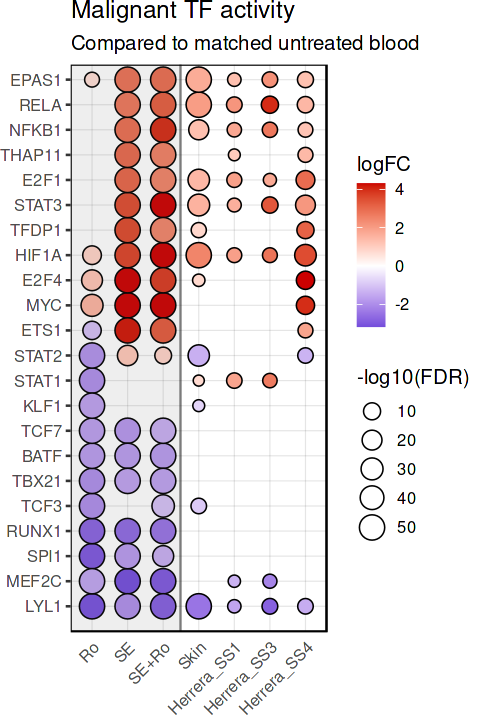

In [12]:
TF_DE_q99 <- quantile(TF_DE$logFC, probs=0.95)
TF_DE$logFC[TF_DE$logFC > TF_DE_q99] <- TF_DE_q99
TF_DE_FDR_q99 <- quantile(TF_DE$FDR, probs=0.1)
pval_max <- 10^-50
TF_DE$FDR[TF_DE$FDR < pval_max] <- pval_max

plots$TF <- TF_DE %>% 
    ggplot(aes(x=donor, y=gene, size=-log10(FDR), fill=logFC)) + 
        geom_point(shape=21) + 
        scale_fill_gradient2(low="#0000CC", high="#CC0000", mid="white", midpoint=0) + 
        scale_size_continuous(range=c(2.5, 6.5)) + 
        #scale_x_discrete(expand=c(0,0,0,0)) + 
        theme(axis.text.y=element_text(), strip.clip = "off",
              axis.text.x=element_text(angle=45, hjust=1),
              axis.line.y=element_blank(),
              axis.ticks.x=element_blank(),
              strip.text.x=element_text(angle=0, face = "bold", hjust=1),
              plot.margin=margin(0,0,0,0, "pt"), 
              axis.line=element_blank(),
              panel.grid.major=element_line(color=alpha("black", 0.1), size=0.25),
              panel.border=element_rect(fill=alpha("white", 0))) + 
        labs(title="Malignant TF activity", subtitle="Compared to matched untreated blood", x="Comparison", y="Pathway") + 
        geom_vline(xintercept=3.5, linetype="solid", alpha=0.5) + 
        annotate(geom="rect", xmin=-Inf, xmax=3.5, ymin=0, ymax=Inf, alpha = 0.1)


pdf(file=here::here("data", "figures", "Malignant_TF_activity_skin_vs_blood.pdf"), width=4, height=6)
plots$TF
dev.off()

options(repr.plot.width=4, repr.plot.height=6)
plots$TF

### Cell cycle and activation plots ###

`summarise()` has grouped output by 'group_short'. You can override using the `.groups` argument.


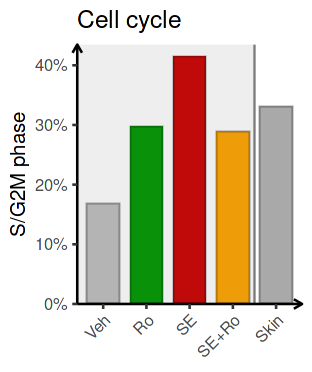

In [13]:
data_plot_cc <- colData(sce)[sce$cell_type == "Malignant", c("tissue", "group_short","cc_phase")] %>% as.data.frame() %>%
    mutate(cc=gsub("S", "G2M", cc_phase) %>% gsub("G2M", "S/G2M", .)) %>% 
    group_by(group_short, cc) %>% summarize(count=n()) %>% 
    group_by(group_short) %>% mutate(count_sample=sum(count), freq=count/count_sample) %>% 
    filter(cc != "G1")    


plots$cell_cycle <- data_plot_cc %>% ggplot(aes(x=group_short, fill=group_short, y=freq)) + 
        geom_col(color=alpha("black",0.25), width=0.75) + 
        #scale_fill_manual(values=c("S/G2M"="black")) + 
        scale_fill_manual(values=metadata(sce)$colors$group_short) + 
        scale_y_continuous(expand=c(0,0,0.05,0), labels = scales::percent) + 
        geom_vline(xintercept=4.5, linetype="solid", alpha=0.5) + 
        annotate(geom="rect", xmin=-Inf, xmax=4.5, ymin=0, ymax=Inf, alpha = 0.1) + 
        theme(legend.position="none", 
              axis.text.x=element_text(angle=45, hjust=1), 
              axis.title.y=element_text(),
              axis.text.y=element_text()) + 
        labs(title="Cell cycle", y="S/G2M phase")

options(repr.plot.width=2.6, repr.plot.height=3+0.1)
plots$cell_cycle

Joining, by = "BC"


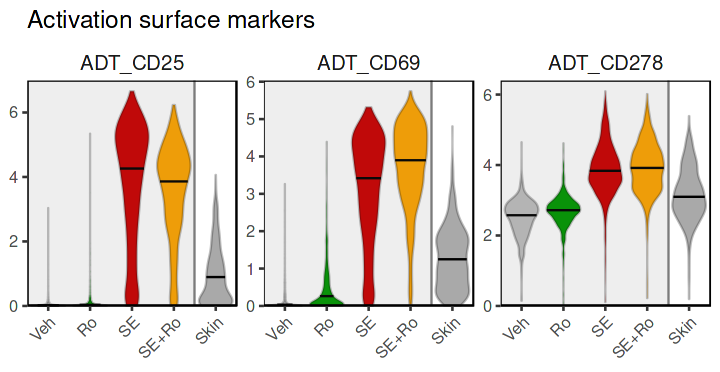

In [14]:
markers <- paste0("ADT_", c("CD25", "CD69", "CD278"))

data_plot_proteins <- colData(sce)[sce$cell_type == "Malignant", c("group_short"), drop=FALSE] %>% as.data.frame() %>% tibble::rownames_to_column("BC") %>% 
    left_join(logcounts(altExp(sce, "ADT"))[markers,sce$cell_type == "Malignant", drop=FALSE] %>% t() %>% as.data.frame() %>% tibble::rownames_to_column("BC")) %>% 
    tidyr::pivot_longer(-c(BC, group_short)) %>% mutate(name=factor(name, levels=markers))


plots$proteins <- data_plot_proteins %>% 
    ggplot(aes(x=group_short, y=value, fill=group_short)) + 
    geom_violin(scale="width", width=0.8, color=alpha("black", 0.25), draw_quantiles = c(0.5)) +
    geom_vline(xintercept=4.5, linetype="solid", alpha=0.5) + 
    annotate(geom="rect", xmin=-Inf, xmax=4.5, ymin=0, ymax=Inf, alpha = 0.1) + 
    scale_fill_manual(values=metadata(sce)$colors[["group_short"]]) + 
    scale_y_continuous(expand=c(0,0,0.05,0)) + 
    scale_x_discrete(expand=c(0.125,0)) + 
    facet_wrap(~ name, nrow=1, scale="free_y") + 
    theme(panel.border=element_rect(fill=alpha("white", 0), color="black"), 
          legend.position="none",
          axis.text.y=element_text(), 
          axis.text.x=element_text(angle=45, hjust=1), 
          axis.line=element_blank()) + 
    labs(title="Activation surface markers")

options(repr.plot.width=2*length(markers), repr.plot.height=3+0.1)
plots$proteins

png 
  2

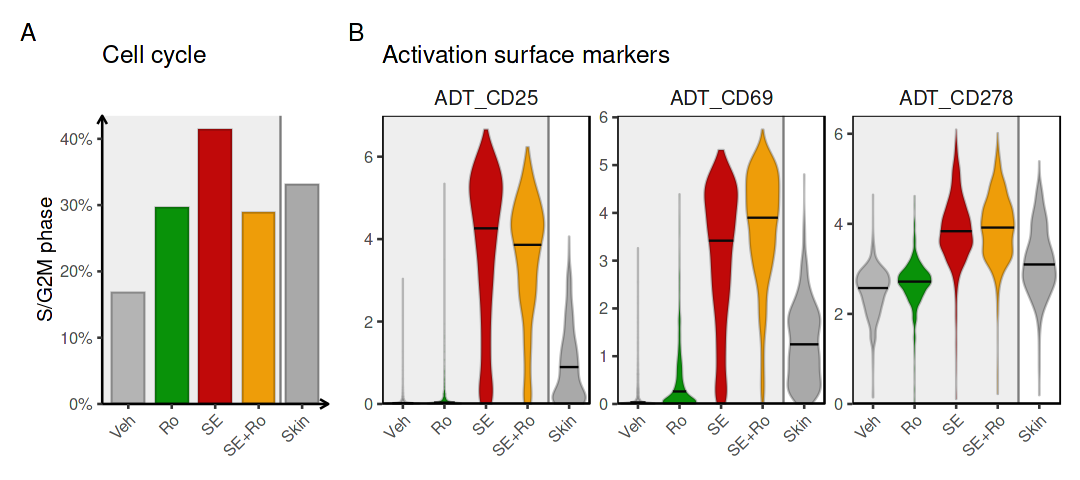

In [15]:
widths <- c(2.25, 2.25*length(markers))
options(repr.plot.width=sum(widths), repr.plot.height=3+1)


plot <- wrap_plots(plots$cell_cycle, plots$proteins, widths=widths, nrow=1) + plot_annotation(tag_levels = 'A')

pdf(file=here::here("data", "figures", "cc_activation_markers.pdf"), height=4, width=sum(widths))
plot
dev.off()

plot